In [3]:
import numpy as np
import cv2
from commonfunctions import *
from skimage import io
from skimage.filters import gaussian, laplace
from skimage.morphology import disk, octagon
from skimage.color import rgb2gray 


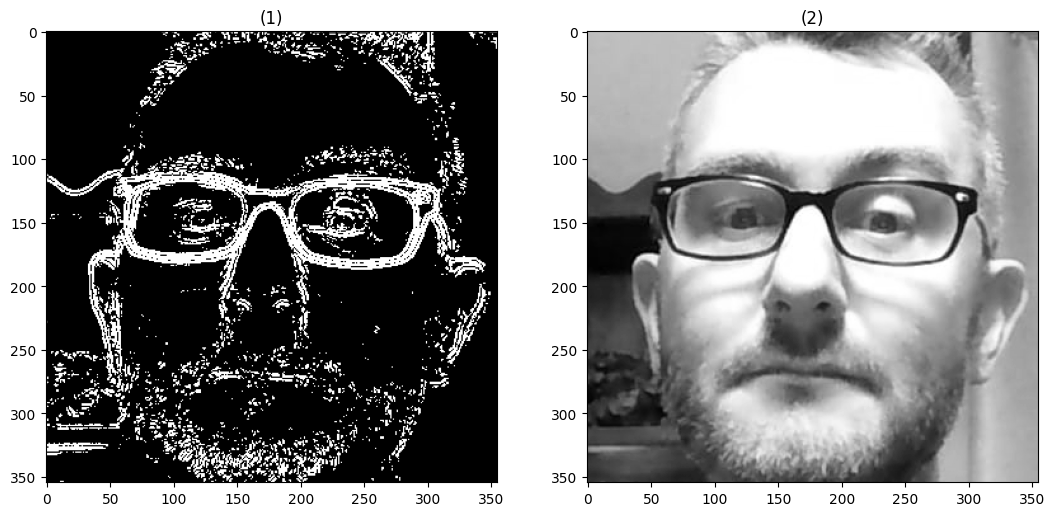

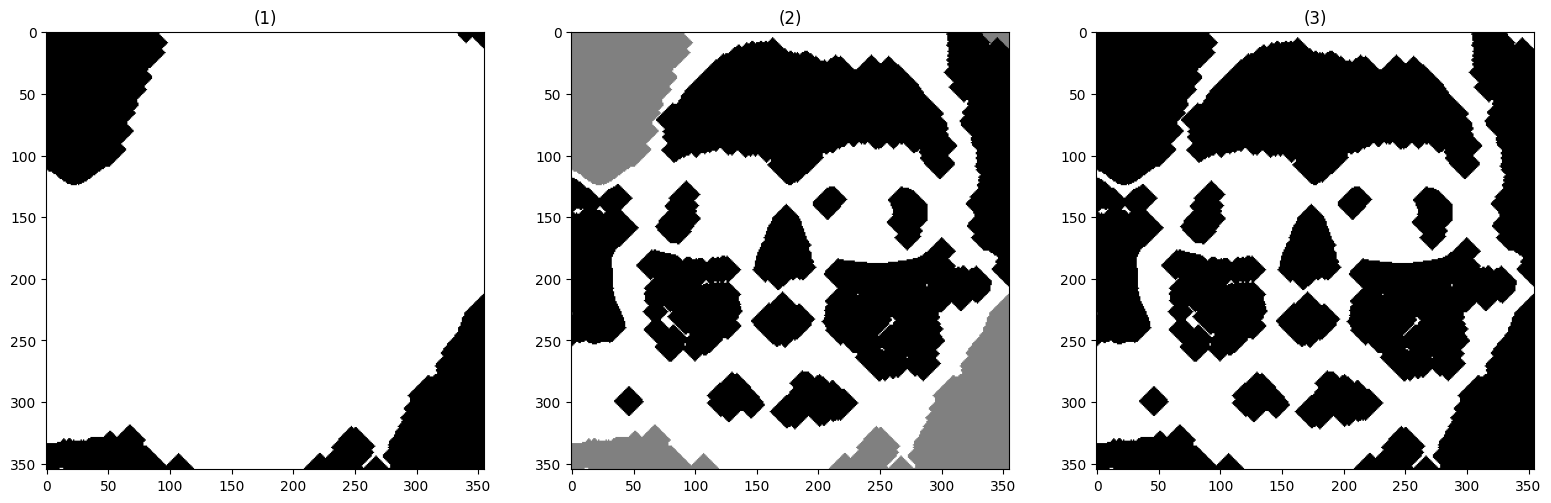

In [130]:
# multiple cascades: https://github.com/Itseez/opencv/tree/master/data/haarcascades

# https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
)
# https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_eye.xml
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
# nose_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_mcs_nose.xml')


img = io.imread('background.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
    # apply our mask -- notice how only the person in the image is
    # cropped out
    # io.imshow(masked)
    # io.imshow(img)
    offst = 5
    x1 = x - offst if x - offst > 0 else 0
    x2 = x + w + offst if x + w + offst < gray.shape[0] else gray.shape[0] 
    y1 = y - offst if y - offst > 0 else 0
    y2 = y + h + offst if y + h + offst < gray.shape[1] else gray.shape[1] 
    w = x2 - x1
    h = y2 - y1 
    roi_gray = gray[y1 : y2, x1 : x2]
    #roi_color = img[y : y + h, x : x + w]
    # img = gaussian(img, 0.5)
    # img = laplace(img)
    blur = cv2.GaussianBlur(roi_gray, (3, 3), 0)
    # Apply Laplacian operator in some higher datatype
    laplacian = np.abs(cv2.Laplacian(blur, cv2.CV_64F))
    thresh = np.max(laplacian)*0.1
    laplacian[laplacian < thresh] = 0
    laplacian[laplacian > thresh] = 1
    show_images([laplacian, roi_gray])
    res = laplacian
    seNoise = disk(2)
    seClose = octagon(7, 4)
    res = cv2.dilate(res, seNoise, iterations=5)
    res = cv2.erode(res, seNoise, iterations=5)

    mask = np.zeros((h+2, w+2), np.uint8)
    final = res.astype(np.uint8) * 255
    cv2.floodFill(final, mask, (0, 0), 128)
    cv2.floodFill(final, mask, (w - 1, h - 1), 128)
    cv2.floodFill(final, mask, (0, h - 1), 128)
    cv2.floodFill(final, mask, (w - 1, 0), 128)
    prethresh = np.copy(final)
    final[final != 128] = 255
    final[final == 128] = 0
    show_images([final, prethresh, res])